## Importing Libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaaa
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
import pickle
from keras.models import load_model

## Exploratory Data Analysis and Preprocessing

In [27]:
data_path = "./data/driving_log.csv"
columns = ['center' , 'left' , 'right' , 'steering' , 'throttle' , 'isReverse' , 'speed']
data = pd.read_csv(data_path , names = columns)

#### Over here , steering angle 0 will get a high bias as we have mostly driven on a straight road . Training our model on the raw data will create high bias towards it . Lets trim the dataset by randomly choosing 300 maximum points per bin for the dataset and making it somewhat like a normal distribution and not biasing the prediction . Looking at throttle , isReverse and speed data distribution , it is inferred that it stays mostly constant . So , not much advantage is gained by training on that .

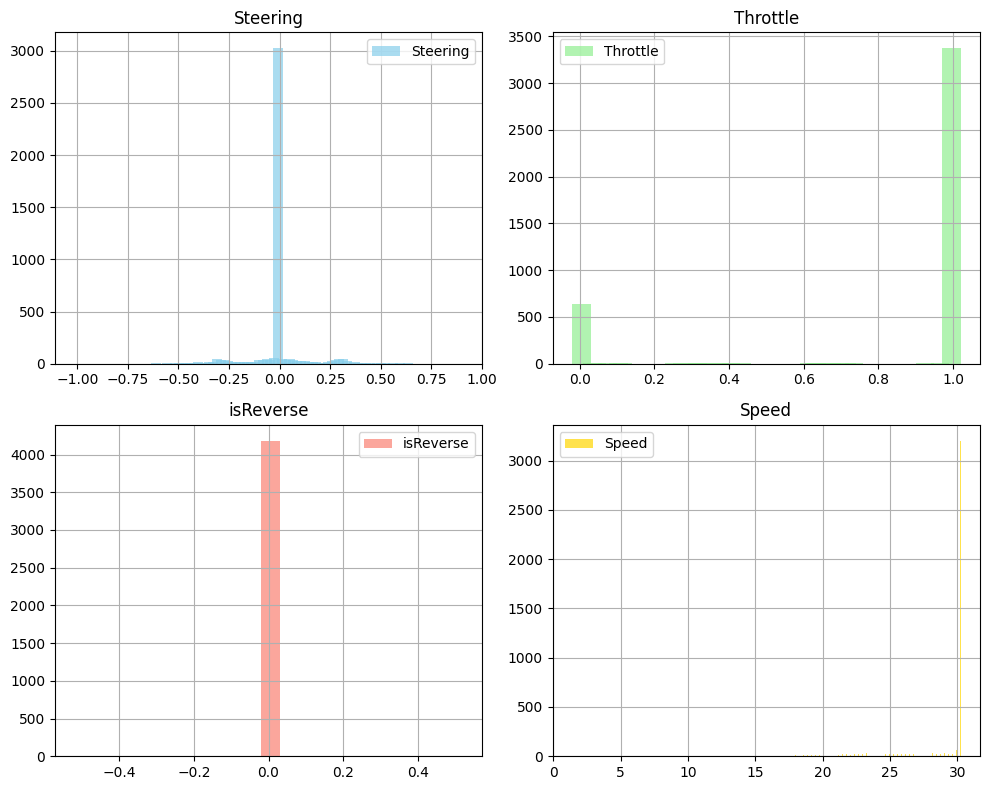

In [28]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histogram parameters
num_bins = 100

# Plot histograms for the first subplot
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
axes[0, 0].bar(center, hist, width=0.05, color='skyblue', alpha=0.7, label='Steering')
axes[0, 0].set_title("Steering")
axes[0, 0].grid(True)
axes[0, 0].legend()

hist, bins = np.histogram(data['throttle'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
axes[0, 1].bar(center, hist, width=0.05, color='lightgreen', alpha=0.7, label='Throttle')
axes[0, 1].set_title("Throttle")
axes[0, 1].grid(True)
axes[0, 1].legend()

hist, bins = np.histogram(data['isReverse'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
axes[1, 0].bar(center, hist, width=0.05, color='salmon', alpha=0.7, label='isReverse')
axes[1, 0].set_title("isReverse")
axes[1, 0].grid(True)
axes[1, 0].legend()

hist, bins = np.histogram(data['speed'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
axes[1, 1].bar(center, hist, width=0.05, color='gold', alpha=0.7, label='Speed')
axes[1, 1].set_title("Speed")
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


<BarContainer object of 100 artists>

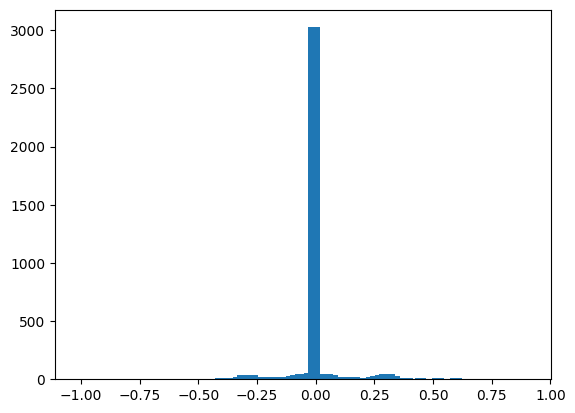

In [29]:
num_bins = 100
hist , bins = np.histogram(data['steering'] , num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center , hist , width = 0.05)

In [30]:
samples_per_bin = 300
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] > bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 2725
remaining: 1460


Text(0.5, 1.0, 'Steering distribution post processing')

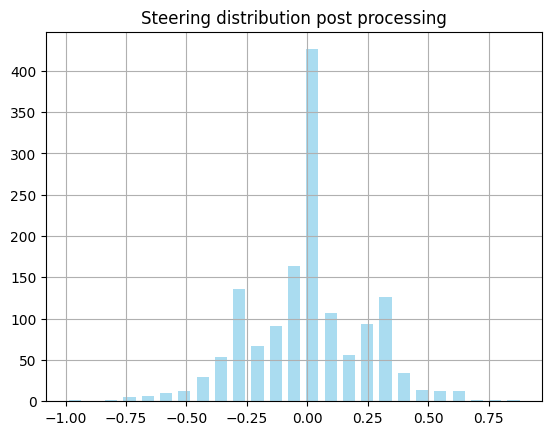

In [31]:
num_bins = 25
hist , bins = np.histogram(data['steering'] , num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center , hist , width = 0.05 , alpha = 0.7 , color = 'skyblue')
plt.grid(True)
plt.title("Steering distribution post processing")

#### Finally saving our processed data 

In [33]:
data.to_csv("./data/processed_log.csv" , index = False)

## Train Test Split

In [8]:
data = pd.read_csv("./data/processed_log.csv")
data.shape

(1460, 7)

In [9]:
# This function loads all the image paths and its corresponding steering angles and returns the two numpy arrays .

def load_img_steering_mapping(data_path , df):
    image_path = []
    steering = []
    for i in range(len(data)):
        row = data.iloc[i]
        #center image append
        image_path.append(row[0].strip())
        steering.append(float(row[3]))
        #left image append 
        image_path.append(row[1].strip())
        steering.append(float(row[3])+0.15)
        #right image append 
        image_path.append(row[2].strip())
        steering.append(float(row[3])-0.15)
    return np.asarray(image_path) , np.asarray(steering)

In [10]:
img_paths , steering_angles = load_img_steering_mapping(".data/IMG/" , data)
print(len(img_paths) , len(steering_angles))

4380 4380


C:\Users\Tejas\AppData\Local\Temp\ipykernel_13108\1963381816.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path.append(row[0].strip())
C:\Users\Tejas\AppData\Local\Temp\ipykernel_13108\1963381816.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(row[3]))
C:\Users\Tejas\AppData\Local\Temp\ipykernel_13108\1963381816.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path.append(row[1].strip

In [11]:
x_train , x_test , y_train , y_test = train_test_split(img_paths , steering_angles , test_size= 0.2 , shuffle = True)
print(len(x_train) , len(x_test))
print(len(y_train) , len(y_test))

3504 876
3504 876


Text(0.5, 0.98, 'Validating both distributions to be similar')

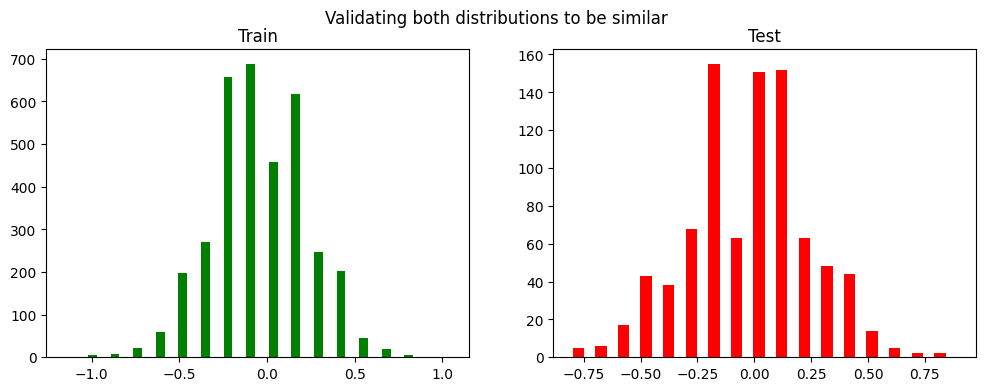

In [12]:
fig , axes = plt.subplots(1 , 2 , figsize = (12,4))
axes[0].hist(y_train , bins = 17 , width = 0.05 , color = 'green')
axes[0].set_title("Train")
axes[1].hist(y_test , bins = 17 , width = 0.05 , color = 'red')
axes[1].set_title("Test")
fig.suptitle("Validating both distributions to be similar")

In [12]:
# Ensuring all the elements are in required format .

for x in img_paths : 
    if not os.path.exists(x):
        print("error")
        break
print("All paths are strings")

if all(isinstance(x, float) for x in steering_angles):
    print("All elements are floats.")
else:
    print("Not all elements are floats.")

All paths are strings
All elements are floats.


In [13]:
# loading all images and steering angles to the lists and then saving to upload it to colab for faster training .
print(type(x_train))
images = []
for img_path in tqdm(img_paths) : 
    images.append(cv2.imread(img_path , cv2.IMREAD_COLOR))
print(type(images))
images = np.array(images)
print(type(images))

np.save('./numpy array data/images.npy' , images)

<class 'numpy.ndarray'>


100%|██████████| 4380/4380 [00:48<00:00, 89.54it/s] 


<class 'list'>
<class 'numpy.ndarray'>


In [14]:
np.save("./numpy array data/steering_angles.npy" , steering_angles)

In [15]:
loaded_array = np.load("images.npy")
for x,y in tqdm(zip(images , loaded_array)):
    if x.all() != y.all():
        print("Not same")
        break
print("Same")
print(loaded_array.shape)

loaded_array = np.load("steering_angles.npy")
for x,y in tqdm(zip(steering_angles , loaded_array)):
    if x.all() != y.all():
        print("Not same")
        break
print("Same")
print(loaded_array.shape)

4380it [00:01, 2598.33it/s]


Same
(4380, 160, 320, 3)


0it [00:00, ?it/s]

Not same
Same
(5175,)


##  Data Augmentation

In [37]:
def load_image(image_path):
    # Over here it was returning as tuple and something string . 
    # Typecasting was necessary and was debugged.
    # But our data augmentation techniques required numpy array with floats .   
    # Finally using opencv library for the entire data augmentation
    return cv2.imread(image_path , cv2.IMREAD_COLOR)

def zoom(image):
  zoom = iaaa.Affine(scale=(1, 1.7))
  image = zoom.augment_image(image)
  return image

def pan(image):
    pan = iaaa.Affine(translate_percent={"x" : (-0.1,0.1) , "y" : (-0.1 , 0.1)})
    image = pan.augment_image(image)
    return image 


def random_brightness_change(image):
    return cv2.convertScaleAbs(image, alpha=random.uniform(0.5,1.5), beta=10)

def flip(image , steering):
    # image  = iaaa.Fliplr(1.0)
    # return image , -steering 
    return cv2.flip(image , 1) , -steering

def random_augment(image_path , steering_angle):
    image = load_image(image_path)
    if np.random.rand()<0.5:
        image = random_brightness_change(image)
        # print("bright")

    if np.random.rand()<0.5:
        image = pan(image)
        # print("panned")

    if np.random.rand()<0.5:
        image = zoom(image)
        # print("zoomed"/)

    if np.random.rand()<0.5:
        image = flip(image , steering_angle)[0]
        steering_angle = -steering_angle
        # print("flipped")

    return image , steering_angle

In [ ]:
print(type(zoom(load_image(img_paths[0]))))
print(type(random_brightness_change(load_image(img_paths[0]))))
print(type(pan(load_image(img_paths[0]))))

In [18]:
for x,y in tqdm(zip(img_paths , steering_angles)) :
    if not zoom(load_image(x)).shape == (160,320,3):
        print("error")
        break
    if not pan(load_image(x)).shape == (160,320,3):
        print("Error")
        break
    if not random_brightness_change(load_image(x)).shape == (160,320,3) :
        print("Error random")
        break
    # if not flip(load_image(x) , y)[0].shape == (160,320,3):
    #     print("error flip")
    #     break
    random_augment(x, y)

print("Data Augmentation works")

4380it [00:47, 92.82it/s] 

Data Augmentation works


-0.2583801
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


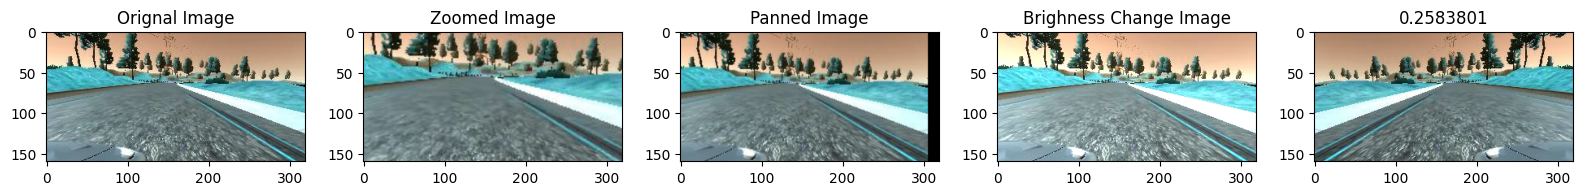

In [19]:
random_index = random.randint(0 , len(img_paths)-1)
image = img_paths[random_index]
orignal = load_image(image)
zoomed_image = zoom(orignal)
panned_image = pan(orignal)
random_brightness_image = random_brightness_change(orignal)
flipped_image , steering = flip(orignal , steering_angles[random_index])
print(steering_angles[random_index])

fig , axes = plt.subplots(1 , 5 , figsize = (16,12))
fig.tight_layout()

axes[0].imshow(orignal)
axes[0].set_title("Orignal Image")
print(type(orignal))

axes[1].imshow(zoomed_image)
axes[1].set_title("Zoomed Image")
print(type(zoomed_image))

axes[2].imshow(panned_image)
axes[2].set_title("Panned Image")
print(type(panned_image))

axes[3].imshow(random_brightness_image)
axes[3].set_title("Brighness Change Image")
print(type(random_brightness_image))

axes[4].imshow(flipped_image)
axes[4].set_title(f"{steering}")
print(type(flipped_image))


## Image Preprocessing for the  Model

In [20]:
def img_preprocess(img):

    # Validate if img is a numpy array
    if not isinstance(img, np.ndarray):
        raise TypeError("Expected a numpy array, but got a different type.")

    # Validate the shape of the image (should be 2D or 3D for images)
    if img.ndim not in [2, 3]:
        raise ValueError("Invalid image dimensions. Expected 2D or 3D, but got something else.")


    img = img[50:150 , :] # Just cropping the image
    img = cv2.cvtColor(img , cv2.COLOR_RGB2YUV) # For the nvidia model color scheme
    img = cv2.GaussianBlur(img , (3,3) , 0) # Eliminating noise
    img = cv2.resize(img , (200,66)) # Resizing for the model parameters
    img = img/255 # Normalizing 
    return img

Text(0.5, 1.0, '(66, 200, 3)')

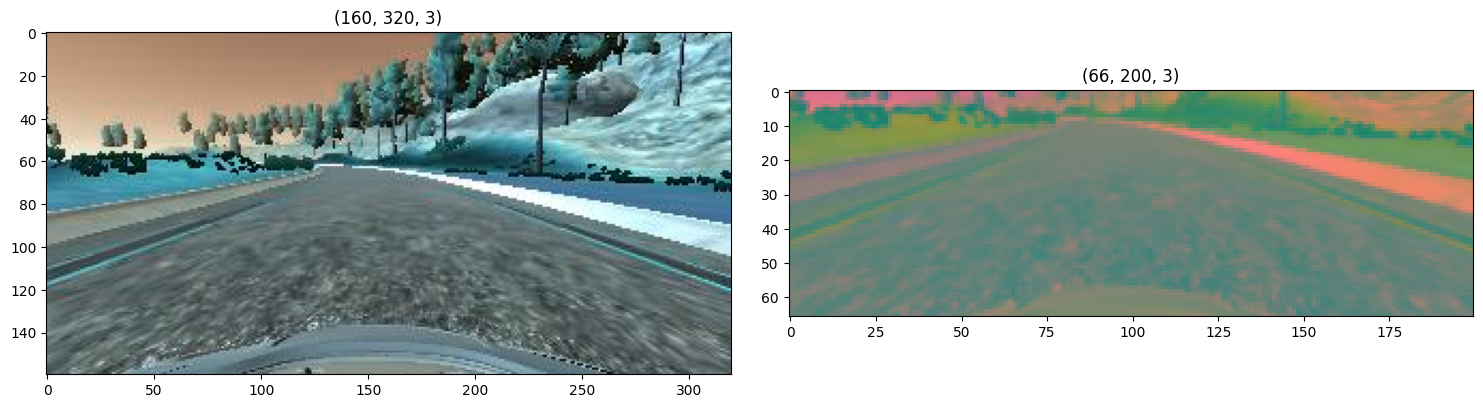

In [21]:
image = img_paths[random.randint(0 , len(data)-1)]
orignal = load_image(image)
preprocessed = img_preprocess(orignal)

fig , axes = plt.subplots(1 , 2 , figsize = (15,10))
fig.tight_layout()
axes[0].imshow(orignal)
axes[0].set_title(orignal.shape)
axes[1].imshow(preprocessed)
axes[1].set_title(preprocessed.shape)


## Batch Generation

In [22]:

def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im , steering = random_augment(img_paths[random_index] , steering_ang[random_index])
      
      else:
        im = load_image(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

<class 'numpy.ndarray'>


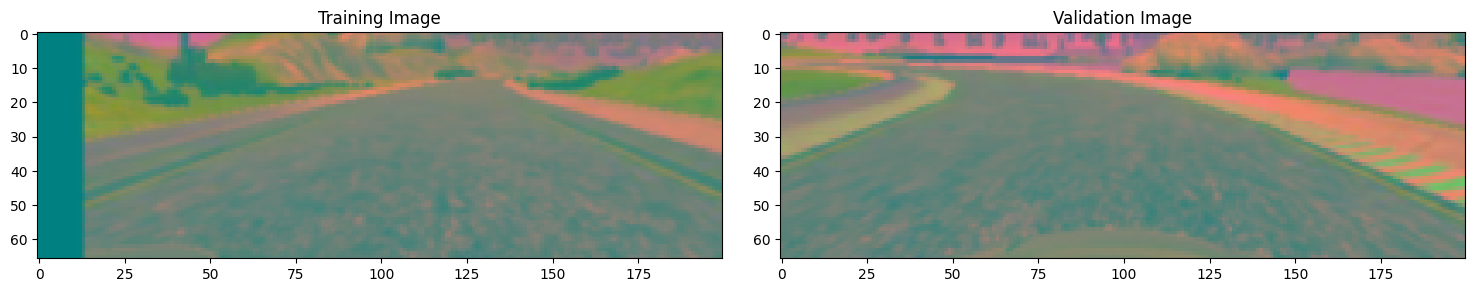

In [23]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_test, y_test, 1, 0))


fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

print(type(x_train_gen[0]))
     

## Architecture of Neural Network

In [27]:
def self_driving_model():
    model = Sequential()

    # Convolutional Neural Network
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (5, 5), activation='elu'))
    model.add(Dropout(0.5))

    # Dense Neural Network
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = self_driving_model()

# model.compile(
#     optimizer='adam',            # The optimizer to use
#     loss='mean-squared-error',  # Loss function for binary classification
#     # metrics=['accuracy'] ,        # Metrics to evaluate during training
#     learning_rate = 1e-3
# )

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

## Training

In [65]:
history = model.fit(
    batch_generator(x_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(x_test, y_test, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle = 1
)

Epoch 1/10
300/300 [==============================] - 274s 909ms/step - loss: 0.1240 - val_loss: 0.0677
Epoch 2/10
300/300 [==============================] - 375s 1s/step - loss: 0.0774 - val_loss: 0.0663
Epoch 3/10
300/300 [==============================] - 426s 1s/step - loss: 0.0754 - val_loss: 0.0666
Epoch 4/10
153/300 [==============>...............] - ETA: 3:03 - loss: 0.0739

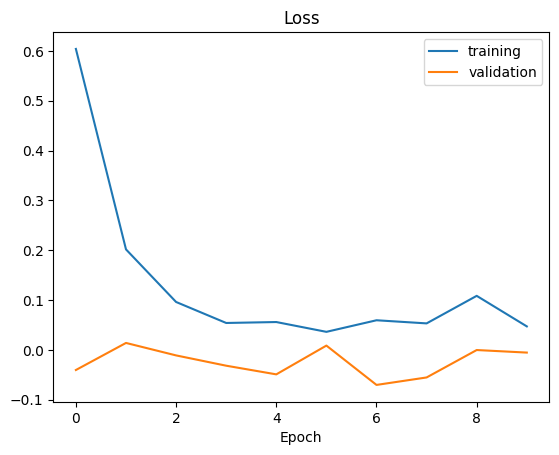

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.savefig("./numpy array data/Progess_graphs_10may.png")

In [ ]:
model.save("./models/drive_mse_10may.h5")

c:\Users\Tejas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing

In [28]:
# model = load_model("models/model_weights_01.h5")
model.load_weights("models/model_weights_01.h5")

In [59]:
for i in tqdm(range(100)):
    model.evaluate(batch_generator(x_test , y_test , 8 , 1))

  0%|          | 0/100 [00:00<?, ?it/s]

    109/Unknown - 4s 33ms/step - loss: 0.1586

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [58]:
for i in tqdm(range(100)):
    model.evaluate(batch_generator(x_test , y_test , 8 , 0))

  0%|          | 0/100 [00:00<?, ?it/s]

   1389/Unknown - 27s 19ms/step - loss: 0.0715

  0%|          | 0/100 [00:27<?, ?it/s]


KeyboardInterrupt: 